Practical Data Science
Project 2

Josh Ragen
Jeremy Xue

Permalink to full data source
http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2016-permalink/c992f36d933723fd033ccdb9c3ef2a33

Permalink to specific data source (just HIV/AIDS, TB, Malaria)
http://ghdx.healthdata.org/gbd-results-tool?params=gbd-api-2016-permalink/acffd0c7209d119075df13f7fb5802da


Loading the data in:

In [54]:
import pandas as pd
import numpy as np
import copy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
import scipy.stats as stats
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import preprocessing

In [2]:
#dat = pd.read_csv('full_data.csv')
dat = pd.read_csv('reduced_data.csv')
dat = dat.drop(['upper', 'lower', 'measure', 'sex'], axis = 1)
dat

,location,age,cause,metric,year,val
0,Kenya,Under 5,Tuberculosis,Number,2000,333.036316
1,Kenya,Under 5,Tuberculosis,Rate,2000,6.454670
2,Kenya,Under 5,Neglected tropical diseases and malaria,Number,2000,9546.056132
3,Kenya,Under 5,Neglected tropical diseases and malaria,Rate,2000,185.014795
4,Kenya,5-14 years,Neglected tropical diseases and malaria,Number,2000,1300.215171
5,Kenya,5-14 years,Neglected tropical diseases and malaria,Rate,2000,14.941310
6,Kenya,15-49 years,Neglected tropical diseases and malaria,Number,2000,1533.580658
7,Kenya,15-49 years,Neglected tropical diseases and malaria,Rate,2000,10.357415
8,Kenya,50-69 years,Neglected tropical diseases and malaria,Number,2000,905.006296
9,Kenya,50-69 years,Neglected tropical diseases and malaria,Rate,2000,45.708312


In [3]:
dat.cause = dat.cause.replace(['HIV/AIDS', 'Tuberculosis', 'Malaria'], ['hiv', 'tb', 'mal'])

dat = dat[dat.cause != 'Neglected tropical diseases and malaria']
dat.age.value_counts()
#dat = dat[dat['age'] == 'Under 5']


Under 5        19788
15-49 years    19788
70+ years      19788
5-14 years     19788
50-69 years    19788
Name: age, dtype: int64

In [4]:
#dat.merge(dat, left_on = ['location', 'age', 'metric', 'year', 'cause'], right_on= ['location', 'age', 'metric', 'year', 'cause']).head()

#dat is just the data frame
#'col' is what gets split into multiple new columns
#'samecols' is what to keep as the constants, they MUST be unique factor combinations for each row
#'vals' is what numbers we want to go into the new coulumns
#'rm_col' says whether to get rid of the original value column (only do if you don't want to use it again)
#Function to run the pivot
def splitrow(dat, col, samecols, vals, rm_col = True):
    df = copy.deepcopy(dat)
    #need to know how many unique levels there are for later
    n = len(df[col].value_counts())
    #Creating a single column to join on, as pivot requires it
    df['joincol'] = df[samecols].apply(lambda x: ''.join(x.astype(str)), axis=1)
    #Pivoting the table to make a new one with the columns we need
    tempdf = df.pivot(index = 'joincol', columns = col, values = vals)
    tempdf['joincol'] = tempdf.index
    #Merging together the two tables into one
    df = tempdf.merge(df, how = 'inner', on = 'joincol')
    #removing the join column
    df = df.drop(['joincol', vals], axis = 1)
    #If we want to remove the original column (no more joins to make), we remove duplicate rows
    if rm_col == True:
        df = df.drop(col, axis = 1)
        df = df.iloc[::n].reset_index()
        df = df.drop('index', axis = 1)
    return(df)

df = splitrow(dat, 'cause', ['location', 'age', 'metric', 'year'], 'val')

In [5]:
print(len(df))
df

32980


,hiv,mal,tb,location,age,metric,year
0,42.913628,771.122729,7138.658456,Afghanistan,15-49 years,Number,2000
1,45.543918,815.365474,7314.421455,Afghanistan,15-49 years,Number,2001
2,48.742938,894.241365,7277.983272,Afghanistan,15-49 years,Number,2002
3,52.410990,959.198303,7338.422563,Afghanistan,15-49 years,Number,2003
4,56.410928,973.515865,7419.208364,Afghanistan,15-49 years,Number,2004
5,60.669123,1005.361284,7380.569093,Afghanistan,15-49 years,Number,2005
6,64.718914,1030.273832,7327.581444,Afghanistan,15-49 years,Number,2006
7,68.885252,1036.418240,7180.659954,Afghanistan,15-49 years,Number,2007
8,73.398280,1048.697136,7042.798090,Afghanistan,15-49 years,Number,2008
9,77.863640,1054.140110,6897.832141,Afghanistan,15-49 years,Number,2009


In [6]:
df = splitrow(df, 'metric', ['location', 'age', 'year'], 'hiv', rm_col = False)
df = df.rename(columns = {'Number':'hiv_num', 'Rate':'hiv_rate'})

df = splitrow(df, 'metric', ['location', 'age', 'year'], 'tb', rm_col = False)
df = df.rename(columns = {'Number':'tb_num', 'Rate':'tb_rate'})

df = splitrow(df, 'metric', ['location', 'age', 'year'], 'mal')
df = df.rename(columns = {'Number':' mal_num', 'Rate':'mal_rate'})

df.head()

,mal_num,mal_rate,tb_num,tb_rate,hiv_num,hiv_rate,location,age,year
0,771.122729,9.054106,7138.658456,83.818267,42.913628,0.503869,Afghanistan,15-49 years,2000
1,815.365474,9.166599,7314.421455,82.231059,45.543918,0.512019,Afghanistan,15-49 years,2001
2,894.241365,9.564549,7277.983272,77.843223,48.742938,0.521340,Afghanistan,15-49 years,2002
3,959.198303,9.741092,7338.422563,74.524995,52.410990,0.532257,Afghanistan,15-49 years,2003
4,973.515865,9.412766,7419.208364,71.735113,56.410928,0.545428,Afghanistan,15-49 years,2004


In [7]:
codes = pd.read_csv('country_codes.csv')

codes = codes.drop_duplicates()
#codes.head()

In [8]:
#This merges in the country codes, but more importantly, it puts in info about what part of the world each country is in.
print(len(df))
df = df.merge(codes, how = 'left', left_on = 'location', right_on = 'location')
print(len(df))
df.columns

16490
16490


Index([' mal_num', 'mal_rate', 'tb_num', 'tb_rate', 'hiv_num', 'hiv_rate',
       'location', 'age', 'year', 'location_code', 'gbd_region',
       'gbd_superregion'],
      dtype='object')

Source of data
http://data.uis.unesco.org/#

In [9]:
demo = pd.read_csv('demographic_data.csv')
print(demo.Indicator.value_counts())
#demo.DEMO_IND.value_counts()

Total population                                                            3961
Population growth (annual %)                                                3879
Rural population (% of total population)                                    3865
Population aged 65 years or older                                           3807
Population aged 14 years or younger                                         3807
Population aged 15-24 years                                                 3807
Population aged 25-64 years                                                 3807
GDP (current LCU)                                                           3734
GDP per capita (current LCU)                                                3696
DEC alternative conversion factor (LCU per US$)                             3645
GNI (current LCU)                                                           3614
GDP per capita (current US$)                                                3603
GDP (current US$)           

In [10]:
demo = pd.read_csv('demographic_data.csv')
#Only keeping 6 indicators, Total Population, Population Growth, Rural Population,
#   GDP (USD), GDP per capita (USD), and Fertility Rate.
demo = demo.drop(['TIME', 'Flag Codes', 'Flags'], axis = 1)
keepFacs = ['200101', 'SP_POP_GROW', 'SP_RUR_TOTL_ZS', 'SP_DYN_IMRT_IN',
            'NY_GDP_PCAP_CD', 'NY_GDP_MKTP_CD', 'SP_DYN_TFRT_IN', 'SP_DYN_LE00_IN']
keepInd = []
for i in range(len(demo)):
    if demo.DEMO_IND[i] not in keepFacs:
        keepInd.append(False)
    else:
        keepInd.append(True)
demo = demo[keepInd]

In [11]:
demo.head()

,DEMO_IND,Indicator,LOCATION,Country,Time,Value
0,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,1999,1.755
1,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,2000,1.756
2,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,2001,1.739
3,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,2002,1.756
4,SP_DYN_TFRT_IN,"Fertility rate, total (births per woman)",AUS,Australia,2003,1.748


In [12]:
#Reshaping the data here
dem_p = splitrow(demo, 'DEMO_IND', ['LOCATION', 'Country', 'Time'], 'Value')

dem_p = dem_p.rename(columns = {'200101':'Population', 'NY_GDP_MKTP_CD':'GDP', 'NY_GDP_PCAP_CD':'GDPperCapita',
                                'SP_DYN_IMRT_IN':'InfantMortality', 'SP_DYN_LE00_IN':'LifeExpectancy',
                               'SP_DYN_TFRT_IN':'FertilityRate', 'SP_POP_GROW':'Pop_growth', 'SP_RUR_TOTL_ZS':'RuralPop'})

#dem_p
dem_p


,Population,GDP,GDPperCapita,InfantMortality,LifeExpectancy,FertilityRate,Pop_growth,RuralPop,Indicator,LOCATION,Country,Time
0,89.005,1.722799e+09,19356.20339,NaN,73.67949,1.903,1.96056,52.873,"Fertility rate, total (births per woman)",ABW,Aruba,1999
1,90.853,1.873453e+09,20620.70063,NaN,73.72420,1.872,2.05503,53.283,"Life expectancy at birth, total (years)",ABW,Aruba,2000
2,92.898,1.920263e+09,20670.65566,NaN,73.78444,1.846,2.22593,53.661,Population growth (annual %),ABW,Aruba,2001
3,94.992,1.941095e+09,20434.29944,NaN,73.86217,1.823,2.22906,54.028,Rural population (% of total population),ABW,Aruba,2002
4,97.017,2.021302e+09,20834.51020,NaN,73.95883,1.803,2.10935,54.394,GDP (current US$),ABW,Aruba,2003
5,98.737,2.228279e+09,22567.82492,NaN,74.07190,1.787,1.75735,54.760,GDP per capita (current US$),ABW,Aruba,2004
6,100.031,2.331006e+09,23302.83199,NaN,74.19990,1.774,1.30204,55.125,Total population,ABW,Aruba,2005
7,101.220,2.623726e+09,25921.02605,NaN,74.48276,1.763,0.38406,55.853,"Fertility rate, total (births per woman)",ABW,Aruba,2007
8,101.353,2.791961e+09,27546.89939,NaN,74.62768,1.764,0.13131,56.217,"Life expectancy at birth, total (years)",ABW,Aruba,2008
9,101.453,2.498933e+09,24631.43486,NaN,74.77115,1.769,0.09862,56.579,Population growth (annual %),ABW,Aruba,2009


In [13]:
df_mod = df.merge(dem_p, how = 'left', left_on = ['location', 'year'], right_on = ['Country', 'Time'])

df_mod.columns
df

,mal_num,mal_rate,tb_num,tb_rate,hiv_num,hiv_rate,location,age,year,location_code,gbd_region,gbd_superregion
0,771.122729,9.054106,7138.658456,83.818267,42.913628,0.503869,Afghanistan,15-49 years,2000,AFG,"Asia, South",North Africa and Middle East
1,815.365474,9.166599,7314.421455,82.231059,45.543918,0.512019,Afghanistan,15-49 years,2001,AFG,"Asia, South",North Africa and Middle East
2,894.241365,9.564549,7277.983272,77.843223,48.742938,0.521340,Afghanistan,15-49 years,2002,AFG,"Asia, South",North Africa and Middle East
3,959.198303,9.741092,7338.422563,74.524995,52.410990,0.532257,Afghanistan,15-49 years,2003,AFG,"Asia, South",North Africa and Middle East
4,973.515865,9.412766,7419.208364,71.735113,56.410928,0.545428,Afghanistan,15-49 years,2004,AFG,"Asia, South",North Africa and Middle East
5,1005.361284,9.301748,7380.569093,68.286092,60.669123,0.561319,Afghanistan,15-49 years,2005,AFG,"Asia, South",North Africa and Middle East
6,1030.273832,9.261394,7327.581444,65.869495,64.718914,0.581775,Afghanistan,15-49 years,2006,AFG,"Asia, South",North Africa and Middle East
7,1036.418240,9.089888,7180.659954,62.977854,68.885252,0.604157,Afghanistan,15-49 years,2007,AFG,"Asia, South",North Africa and Middle East
8,1048.697136,8.985033,7042.798090,60.341325,73.398280,0.628862,Afghanistan,15-49 years,2008,AFG,"Asia, South",North Africa and Middle East
9,1054.140110,8.801511,6897.832141,57.593243,77.863640,0.650120,Afghanistan,15-49 years,2009,AFG,"Asia, South",North Africa and Middle East


In [14]:
test = df_mod['gbd_region'].astype('category')
test1 = test.unique()
test1.categories

Index(['Asia, South', 'Europe, Central', 'North Africa/Middle East',
       'Sub-Saharan Africa, Central', 'Latin America, Southern',
       'Asia, Central', 'Caribbean', 'Europe, Eastern',
       'Sub-Saharan Africa, Western', 'Latin America, Andean',
       'Sub-Saharan Africa, Southern', 'Latin America, Tropical',
       'Sub-Saharan Africa, Eastern', 'Asia, Southeast', 'Asia, East',
       'Latin America, Central', 'Oceania', 'Europe, Western',
       'Asia Pacific, high-income'],
      dtype='object')

In [15]:
#Fitting the model here, setting the predicted variable (mal_num) as being predicted by a combination of other factors
#mod = ols(formula = "hiv_rate ~ age + gbd_region + gbd_superregion + Population + GDP + GDPperCapita + FertilityRate + Pop_growth + RuralPop",
#          data = df_mod).fit()
formt = "hiv_rate ~ age + gbd_region + gbd_superregion + Population + GDP + GDPperCapita + FertilityRate + InfantMortality + Pop_growth + RuralPop"
#mod = ols(formula = formt, data = df_mod).fit()
#mod.summary()
mod = ols(formula = formt, data = df_mod)
model = mod.fit()
lassoFit = mod.fit_regularized(method='elastic_net', L1_wt=1.0, alpha = 0.01)
#Need to do this workaround because of bug in statsmodels
final = sm.regression.linear_model.OLSResults(mod, lassoFit.params, model.normalized_cov_params)
print(np.mean(final.resid**2))
final.summary()

#lassoFit.params

15154.818393615524


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               hiv_rate   R-squared:                       0.544
Model:                            OLS   Adj. R-squared:                  0.543
Method:                 Least Squares   F-statistic:                     383.3
Date:                Sun, 06 May 2018   Prob (F-statistic):               0.00
Time:                        23:05:43   Log-Likelihood:                -60201.
No. Observations:                9660   AIC:                         1.205e+05
Df Residuals:                    9629   BIC:                         1.207e+05
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=============================================================================================================================
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------------------------
Intercept                                                     9.3345      6.245      1.495      0.135      -2.908      21.577
age[T.5-14 years]                                           -91.0023      3.970    -22.921      0.000     -98.785     -83.220
age[T.50-69 years]                                           10.8246      3.968      2.728      0.006       3.047      18.602
age[T.70+ years]                                            -48.0048      3.967    -12.100      0.000     -55.781     -40.228
age[T.Under 5]                                              -63.1961      3.967    -15.929      0.000     -70.973     -55.419
gbd_region[T.Asia, Central]                                 -15.6602      4.661     -3.360      0.001     -24.796      -6.524
gbd_region[T.Asia, East]                                     76.1687     23.147      3.291      0.001      30.796     121.542
gbd_region[T.Asia, South]                                   -26.5642      8.427     -3.152      0.002     -43.082     -10.046
gbd_region[T.Asia, Southeast]                                72.6661      8.012      9.069      0.000      56.960      88.372
gbd_region[T.Caribbean]                                      19.4471      5.043      3.856      0.000       9.562      29.332
gbd_region[T.Europe, Central]                                      0      5.009          0      1.000      -9.819       9.819
gbd_region[T.Europe, Eastern]                                -1.2082      6.443     -0.188      0.851     -13.838      11.421
gbd_region[T.Europe, Western]                                -3.5752      9.846     -0.363      0.717     -22.876      15.725
gbd_region[T.Latin America, Andean]                          -5.5804      8.248     -0.677      0.499     -21.748      10.588
gbd_region[T.Latin America, Central]                               0      4.984          0      1.000      -9.770       9.770
gbd_region[T.Latin America, Southern]                              0      7.274          0      1.000     -14.258      14.258
gbd_region[T.Latin America, Tropical]                        -6.3378      8.665     -0.731      0.465     -23.323      10.647
gbd_region[T.North Africa/Middle East]                       26.1618      8.235      3.177      0.001      10.019      42.305
gbd_region[T.Oceania]                                        51.8073      9.432      5.493      0.000      33.319      70.296
gbd_region[T.Sub-Saharan Africa, Central]                    14.5528      8.781      1.657      0.097      -2.659      31.764
gbd_region[T.Sub-Saharan Africa, Eastern]                    69.5914      5.851     11.895      0.000      58.123      81.060
gbd_region[T.Sub-Saharan Africa, Southern]                 

In [80]:
#I know there's an easier way than this...
def makeRepSeq(n, f):
    s = n //  f
    l = []
    for i in range(1, f+1):
        l.extend([i] * s)
    return l

#Writing the funciton to run the cross validation
def runFoldCV(dat, params, y, folds):
    datC = dat.dropna(axis=0, how='any')
    dfRand = datC.sample(frac = 1).reset_index(drop = True)
    n = len(dfRand)
    splitSeq = np.array(makeRepSeq(n, folds))
    RsqList = []
    mseList = []
    form = y + '~' + ' + '.join(params)
    for i in range(1, folds+1):
        testdf = dfRand[splitSeq == i]
        traindf = dfRand[splitSeq != i]
        olsf = ols(formula = form, data = traindf)
        modf = olsf.fit()
        #modf = olsf.fit_regularized(method='elastic_net', L1_wt=1.0, alpha = 0.01)
        preds = modf.predict(testdf)
        mse = np.mean((preds - testdf[y])**2)
        mseList.append(mse)
        print(mse)
    return(np.mean(mseList))


terms = ['age', 'gbd_region', 'gbd_superregion', 'Population', 'GDP', 'GDPperCapita',
         'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop']
yvar = 'hiv_rate'
form = yvar + '~' + ' + '.join(terms)

df_mod_clean = df_mod.dropna(axis=0, how='any')
mod = ols(formula = form, data = df_mod_clean)
model = mod.fit()
lassoFit = mod.fit_regularized(method='elastic_net', L1_wt=1.0, alpha = 0.01)
#Need to do this workaround because of bug in statsmodels
final = sm.regression.linear_model.OLSResults(mod, lassoFit.params, model.normalized_cov_params)
print(np.mean(final.resid**2))
print(final.summary())

runFoldCV(df_mod, terms, 'hiv_rate', 5)


14974.617929309137
                            OLS Regression Results                            
Dep. Variable:               hiv_rate   R-squared:                       0.550
Model:                            OLS   Adj. R-squared:                  0.549
Method:                 Least Squares   F-statistic:                     379.5
Date:                Sun, 06 May 2018   Prob (F-statistic):               0.00
Time:                        23:47:12   Log-Likelihood:                -60050.
No. Observations:                9645   AIC:                         1.202e+05
Df Residuals:                    9613   BIC:                         1.204e+05
Df Model:                          31                                         
Covariance Type:            nonrobust                                         
                                                                coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------

13432.692451461136

In [17]:
df_mod_clean['pred_hiv_rate'] = lassoFit.predict(df_mod_clean)


C:\Users\joshr\Miniconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


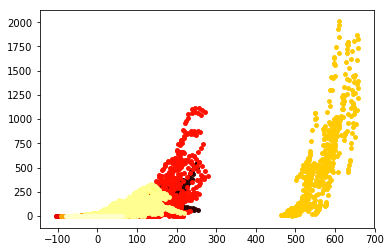

In [18]:
#plt.scatter(lassoFit.fittedvalues, df_mod_clean['mal_rate'])


#plt.scatter(lassoFit.predict(df_2015), df_2015['mal_rate'], c = 'red')
uniq = list(set(df_mod_clean['gbd_region']))
z = range(1,len(uniq))
hot = plt.get_cmap('hot')
cNorm  = colors.Normalize(vmin=0, vmax=len(uniq))
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=hot)

# Plot each species
for i in range(len(uniq)):
    indx = df['gbd_region'] == uniq[i]
    plt.scatter(lassoFit.fittedvalues[indx],df_mod_clean['hiv_rate'][indx], s=15, color=scalarMap.to_rgba(i), label=uniq[i])

#plt.legend(loc='upper left')

#plt.scatter(lassoFit.fittedvalues, df_mod_clean['hiv_rate'], c = df_mod_clean['gbd_region'])




In [36]:
#Helper function to check type of data
def isQuant(L):
    for i in range(len(L)):
        if not (isinstance(L[i], float) or isinstance(L[i], int)):
            return False
    return True

def isCateg(L):
    for i in range(len(L)):
        #NOTE: Want better check, for when data is read in incorrectly.
        if not isinstance(L[i], str):
            return False
    return True

def getPredMatrix(dat, terms, y):
    predMatrix = pd.DataFrame()
    #modDat[y] = self.dat[y]
    predMatrix["Intercept"] = [1] * len(dat)
    for i in range(len(terms)):
        col = terms[i]
        var = dat[col]
        if dat.dtypes[col] == 'float64':
            predMatrix[col] = var
        else:
            #Splitting the different levels up based on how many there are.
            var = var.astype('category')
            un_vals = var.unique().categories
            levels = sorted(list(un_vals))
            #Base Variable is the first alphabetically
            base = levels.pop(0)
            for l in levels:
                newCol = []
                #Need to manually go through and code in 0s and 1s
                for obs in var:
                    if obs == l:
                        newCol.append(1)
                    else:
                        newCol.append(0)
                colName = col + "[T." + l + "]"
                predMatrix[colName] = newCol
    predMatrix[y] = dat[y]
    return predMatrix

terms = ['age', 'gbd_region', 'gbd_superregion', 'Population', 'GDP', 'GDPperCapita',
         'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop']
test = df_mod.dropna(axis=0, how='any')
X = test
X = getPredMatrix(X, terms, 'hiv_rate')
X.columns
X = X.drop(columns=['Intercept'])
X
#Y = X['hiv_rate']
#X = X.drop('hiv_rate', axis = 1)
#reg_mod = LinearRegression()
#reg_mod.fit(X, Y)
#type(df_mod['gbd_region'][1])
#list(set(df_mod.dropna(axis=0, how='any')['gbd_region']))
#for idx, col_name in enumerate(X.columns):
#    print("The coefficient for {} is {}".format(col_name, reg_mod.coef_[idx]))
#reg_mod.score(X, Y)

,age[T.5-14 years],age[T.50-69 years],age[T.70+ years],age[T.Under 5],"gbd_region[T.Asia, East]","gbd_region[T.Asia, South]","gbd_region[T.Asia, Southeast]",gbd_region[T.Caribbean],"gbd_region[T.Europe, Central]","gbd_region[T.Europe, Eastern]",...,gbd_superregion[T.Sub-Saharan Africa],Population,GDP,GDPperCapita,FertilityRate,InfantMortality,LifeExpectancy,Pop_growth,RuralPop,hiv_rate
0,0,0,0,0,0,1,0,0,0,0,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,1,0,0,0,0,...,0,20966.463,2.461666e+09,117.40969,7.392,88.4,56.06071,4.25150,78.404,0.512019
2,0,0,0,0,0,1,0,0,0,0,...,0,21979.923,4.128821e+09,187.84509,7.271,86.1,56.65354,4.72053,78.085,0.521340
3,0,0,0,0,0,1,0,0,0,0,...,0,23064.851,4.583644e+09,198.72854,7.136,83.6,57.26588,4.81804,77.763,0.532257
4,0,0,0,0,0,1,0,0,0,0,...,0,24118.979,5.285466e+09,219.14135,6.988,81.1,57.89122,4.46892,77.438,0.545428
5,0,0,0,0,0,1,0,0,0,0,...,0,25070.798,6.275074e+09,250.29413,6.827,78.5,58.51559,3.87047,77.105,0.561319
6,0,0,0,0,0,1,0,0,0,0,...,0,25893.450,7.057598e+09,272.56308,6.651,76.0,59.12595,3.22863,76.763,0.581775
7,0,0,0,0,0,1,0,0,0,0,...,0,26616.792,9.843842e+09,369.83580,6.460,73.4,59.70885,2.75523,76.413,0.604157
8,0,0,0,0,0,1,0,0,0,0,...,0,27294.031,1.019053e+10,373.36112,6.254,70.8,60.25673,2.51257,76.054,0.628862
9,0,0,0,0,0,1,0,0,0,0,...,0,28004.331,1.248694e+10,445.89330,6.038,68.2,60.76461,2.56911,75.687,0.650120


FrozenList([None])

In [82]:
from sklearn.model_selection import train_test_split
newterms = copy.copy(terms)
terms = ['age[T.5-14 years]', 'age[T.50-69 years]',
       'age[T.70+ years]', 'age[T.Under 5]', 'gbd_region[T.Asia, East]',
       'gbd_region[T.Asia, South]', 'gbd_region[T.Asia, Southeast]',
       'gbd_region[T.Caribbean]', 'gbd_region[T.Europe, Central]',
       'gbd_region[T.Europe, Eastern]', 'gbd_region[T.Europe, Western]',
       'gbd_region[T.Latin America, Andean]',
       'gbd_region[T.Latin America, Central]',
       'gbd_region[T.Latin America, Southern]',
       'gbd_region[T.Latin America, Tropical]',
       'gbd_region[T.North Africa/Middle East]', 'gbd_region[T.Oceania]',
       'gbd_region[T.Sub-Saharan Africa, Central]',
       'gbd_region[T.Sub-Saharan Africa, Eastern]',
       'gbd_region[T.Sub-Saharan Africa, Southern]',
       'gbd_region[T.Sub-Saharan Africa, Western]',
       'gbd_superregion[T.High-income]',
       'gbd_superregion[T.Latin America and Caribbean]',
       'gbd_superregion[T.North Africa and Middle East]',
       'gbd_superregion[T.South Asia]',
       'gbd_superregion[T.Southeast Asia, East Asia, and Oceania]',
       'gbd_superregion[T.Sub-Saharan Africa]', 'Population', 'GDP', 'GDPperCapita',
       'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop', 'hiv_rate']

print(X.columns)
C = X[terms]
C = C.dropna(axis=0, how='any').reset_index(drop = True)
print(C.columns)
Xnew = C.drop(columns=['hiv_rate'])
Y = C['hiv_rate']
X_train, X_test, y_train, y_test = train_test_split(Xnew, Y, test_size=0.3, random_state=45)
reg_mod = LinearRegression()
reg_mod.fit(X_train, y_train)

las_mod = linear_model.Lasso(alpha = 0.02)
las_mod.fit(X_train, y_train)
    
svr_mod = svm.SVR(C = 310, epsilon = 10, kernel = 'rbf')
svr_mod.fit(X_train, y_train)

Index(['age[T.5-14 years]', 'age[T.50-69 years]', 'age[T.70+ years]',
       'age[T.Under 5]', 'gbd_region[T.Asia, East]',
       'gbd_region[T.Asia, South]', 'gbd_region[T.Asia, Southeast]',
       'gbd_region[T.Caribbean]', 'gbd_region[T.Europe, Central]',
       'gbd_region[T.Europe, Eastern]', 'gbd_region[T.Europe, Western]',
       'gbd_region[T.Latin America, Andean]',
       'gbd_region[T.Latin America, Central]',
       'gbd_region[T.Latin America, Southern]',
       'gbd_region[T.Latin America, Tropical]',
       'gbd_region[T.North Africa/Middle East]', 'gbd_region[T.Oceania]',
       'gbd_region[T.Sub-Saharan Africa, Central]',
       'gbd_region[T.Sub-Saharan Africa, Eastern]',
       'gbd_region[T.Sub-Saharan Africa, Southern]',
       'gbd_region[T.Sub-Saharan Africa, Western]',
       'gbd_superregion[T.High-income]',
       'gbd_superregion[T.Latin America and Caribbean]',
       'gbd_superregion[T.North Africa and Middle East]',
       'gbd_superregion[T.South Asia]',


SVR(C=310, cache_size=200, coef0=0.0, degree=3, epsilon=10, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [38]:
print(svr_mod.score(X_test, y_test))

pred_vals = svr_mod.predict(X_test)
np.mean((pred_vals - y_test)**2)

0.31730884026595274


14190.642676495332

In [70]:
#Writing the funciton to run the cross validation
terms = ['age', 'gbd_region', 'gbd_superregion', 'Population', 'GDP', 'GDPperCapita',
         'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop']

def runFoldCV_las(dat, params, y, folds, lam):
    datC = dat.dropna(axis=0, how='any')
    Xlas = getPredMatrix(datC, params, y)
    Xlas = Xlas.drop(columns=['Intercept'])
    termsLAS = Xlas.columns
    Clas = Xlas[termsLAS]
    Clas = Clas.dropna(axis=0, how='any').reset_index(drop = True)
    dfRand = Clas.sample(frac = 1).reset_index(drop = True)
    dfRand = dfRand[:(len(dfRand) - len(dfRand)%5)]
    Xlas = dfRand.drop(columns=[y])
    Ylas = dfRand[y]
    n = len(Xlas)
    splitSeq = np.array(makeRepSeq(n, folds))
    RsqList = []
    mseList = []
    for i in range(1, folds+1):
        x_test, x_train = Xlas[splitSeq == i], Xlas[splitSeq != i]
        y_test, y_train = Ylas[splitSeq == i], Ylas[splitSeq != i]
        las_mod = linear_model.Lasso(alpha = lam)
        las_mod.fit(x_train, y_train)
        
        RsqList.append(las_mod.score(x_test, y_test))
        preds = las_mod.predict(x_test)
        mse = np.mean((preds - y_test)**2)
        mseList.append(mse)
    return(np.mean(mseList), np.mean(RsqList))

runFoldCV_las(df_mod, terms, 'hiv_rate', 5, 0.1)

(13055.613043400577, 0.42414895770351946)

Optimal Output at:
Lambda = 0.02

In [79]:
for i in range(1, 20, 2):
    lam = (i / 200) - 0.005
    res = runFoldCV_las(df_mod, terms, 'hiv_rate', 5, lam)
    print('lambda = ', lam, 'RES =', res)

C:\Users\joshr\Miniconda3\lib\site-packages\ipykernel_launcher.py:24: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
C:\Users\joshr\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
C:\Users\joshr\Miniconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


lambda =  0.0 RES = (12994.536786378287, 0.4361379638789519)
lambda =  0.009999999999999998 RES = (13104.476638255384, 0.42934365846030775)
lambda =  0.02 RES = (13011.586432339005, 0.4320446984695331)
lambda =  0.030000000000000002 RES = (13224.909415180033, 0.3891712894401961)
lambda =  0.04 RES = (13153.783859190871, 0.4218502972014173)
lambda =  0.05 RES = (13118.217351028754, 0.42101676599222354)
lambda =  0.060000000000000005 RES = (13040.819898731905, 0.43273098110006714)
lambda =  0.06999999999999999 RES = (12749.608044279961, 0.42957399166014804)
lambda =  0.08 RES = (13137.330220642849, 0.4245724619838295)
lambda =  0.09 RES = (12978.33237651962, 0.43484882190398)


In [50]:
#Writing the funciton to run the cross validation
terms = ['age', 'gbd_region', 'gbd_superregion', 'Population', 'GDP', 'GDPperCapita',
         'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop']

def runFoldCV_SVR(dat, params, y, folds, c, eps):
    datC = dat.dropna(axis=0, how='any')
    Xsvr = getPredMatrix(datC, params, y)
    Xsvr = Xsvr.drop(columns=['Intercept'])
    termsSVR = Xsvr.columns
    Csvr = Xsvr[termsSVR]
    Csvr = Csvr.dropna(axis=0, how='any').reset_index(drop = True)
    dfRand = Csvr.sample(frac = 1).reset_index(drop = True)
    dfRand = dfRand[:(len(dfRand) - len(dfRand)%5)]
    Xsvr = dfRand.drop(columns=[y])
    Ysvr = dfRand[y]
    n = len(Xsvr)
    splitSeq = np.array(makeRepSeq(n, folds))
    RsqList = []
    mseList = []
    for i in range(1, folds+1):
        x_test, x_train = Xsvr[splitSeq == i], Xsvr[splitSeq != i]
        y_test, y_train = Ysvr[splitSeq == i], Ysvr[splitSeq != i]
        svr_mod = svm.SVR(C = c, epsilon = eps, kernel = 'rbf')
        svr_mod.fit(x_train, y_train)
        RsqList.append(svr_mod.score(x_test, y_test))
        preds = svr_mod.predict(x_test)
        mse = np.mean((preds - y_test)**2)
        mseList.append(mse)
    return(np.mean(mseList), np.mean(RsqList))

runFoldCV_SVR(df_mod, terms, 'hiv_rate', 5, 400, 15)

(15392.21220942109, 0.32336291538405143)

OPTIMAL OUTPUT AT:
C = 310
Epsilon = 10

In [61]:
for i in range(250, 350, 20):
    for j in range(5, 30, 5):
        pass
        #res = runFoldCV_SVR(df_mod, terms, 'hiv_rate', 5, i, j)
        #print('C = ', i, ', Epsilon =', j, 'RES =', res)

C =  250 , Epsilon = 5 RES = (15403.405186095904, 0.33164472687175)
C =  250 , Epsilon = 10 RES = (14782.27634652899, 0.36074526088299047)
C =  250 , Epsilon = 15 RES = (14983.478851020622, 0.35881589505196787)
C =  250 , Epsilon = 20 RES = (14965.066678033123, 0.35105356659563897)
C =  250 , Epsilon = 25 RES = (15228.074124316034, 0.33423403589704453)
C =  270 , Epsilon = 5 RES = (15004.35120589143, 0.35214486065205464)
C =  270 , Epsilon = 10 RES = (14776.619845165105, 0.3524289917606781)
C =  270 , Epsilon = 15 RES = (15438.755131216418, 0.334720381344046)
C =  270 , Epsilon = 20 RES = (14382.216613065533, 0.37751285993873057)
C =  270 , Epsilon = 25 RES = (15134.392167112313, 0.3226294111461654)
C =  290 , Epsilon = 5 RES = (15210.622414012589, 0.3364455769482574)
C =  290 , Epsilon = 10 RES = (14899.385006330285, 0.35394433460283875)
C =  290 , Epsilon = 15 RES = (14986.628283583745, 0.33739701327625815)
C =  290 , Epsilon = 20 RES = (14775.176498302124, 0.35580941604159105)
C =  

In [504]:
newterms = copy.copy(terms)
terms = ['age', 'gbd_region', 'gbd_superregion', 'Population', 'GDP', 'GDPperCapita',
         'FertilityRate', 'InfantMortality', 'LifeExpectancy', 'Pop_growth', 'RuralPop']

X = df_mod[terms]
Y = df_mod['mal_rate']
reg_mod = LinearRegression()
reg_mod.fit(X, Y)


ValueError: could not convert string to float: 'Sub-Saharan Africa'